# **KomuterPulse Model Development: Linear Regression for Ridership Prediction**

This notebook focuses on developing machine learning models for our KomuterPulse project, with special emphasis on XGBoost for ridership prediction. The model will leverage engineered features from our KTM Komuter transit data to forecast hourly ridership between station pairs.

## **Objectives**
1.Load and Prepare Feature-Engineered Data

2.Scale the Input Features

3.Build and Train a Linear Regression Model

4.Evaluate Model Performance

5.Visualize Model Predictions



Let's start by importing the necessary libraries and loading our preprocessed data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import time
import os
import pickle

# For data preprocessing and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# For visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Set random seed for reproducibility
np.random.seed(42)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



## **Data Loading and Preparation**

First, let's load the preprocessed and feature-engineered data along with the feature subsets identified in the feature engineering notebook.

In [4]:
# Define paths for local data
DATA_DIR = Path('../data/processed')
train_path = DATA_DIR / 'komuter_train.csv'
test_path = DATA_DIR / 'komuter_test.csv'
feature_subsets_path = DATA_DIR / 'feature_subsets.pkl'

# Load data
try:
    # Load training and testing data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Training data loaded: {train_df.shape}")
    print(f"Testing data loaded: {test_df.shape}")

    # Load feature subsets
    with open(feature_subsets_path, 'rb') as f:
        feature_subsets = pickle.load(f)
    print("Feature subsets loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the data files are in the correct location in the data/processed directory.")

    # Display the available feature subsets and their sizes
for subset_name, features in feature_subsets.items():
    if isinstance(features, list):
        print(f"{subset_name}: {len(features)} features")
    else:
        print(f"{subset_name}: {features}")

# We'll use the consensus features identified from our feature engineering notebook
selected_features = feature_subsets['consensus_features']
print(f"\nSelected features for Linear Regression model ({len(selected_features)} features):")
print(selected_features)

Training data loaded: (537642, 55)
Testing data loaded: (132957, 55)
Feature subsets loaded successfully.
all_features: 53 features
consensus_features: 18 features
rf_top_features: 15 features
xgb_top_features: 15 features
selectkbest_features: 20 features
pca_n_components: 19

Selected features for Linear Regression model (18 features):
['avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h', 'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d', 'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h', 'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h']


## **Creating the Target Variable**

In [5]:
# Create the target variable by shifting total ridership by -1 hour for each OD pair
train_df['target'] = train_df.groupby(['origin', 'destination'])['total_ridership'].shift(-1)
test_df['target'] = test_df.groupby(['origin', 'destination'])['total_ridership'].shift(-1)

# Drop NA values resulting from the shift
train_df.dropna(subset=['target'], inplace=True)
test_df.dropna(subset=['target'], inplace=True)

## **Feature Selection and Data Normalization**

In [6]:
features = [
    'avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h',
    'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d',
    'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h',
    'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h',
    'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h'
]
# Define X and y
X_train = train_df[features]
y_train = train_df['total_ridership']
X_test = test_df[features]
y_test = test_df['total_ridership']

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## **Feature Selection Using LassoCV and Data Splitting for Validation**

To reduce model complexity and improve generalization, LassoCV (Lasso with cross-validation) is used to automatically select the most relevant features. Lasso penalizes less important features by shrinking their coefficients to zero, leaving only the most predictive features.

Once selected, the dataset is redefined to include only the non-zero coefficient features. These features are then standardized again to ensure consistency in scale before training.

Next, the data is split into training and validation sets using an 80-20 ratio. This allows us to evaluate model performance during training and helps prevent overfitting.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

# --- Use LassoCV to automatically select features
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))
lasso.fit(X_train, y_train)

# Get features with non-zero coefficients
lasso_coef = lasso.named_steps['lassocv'].coef_
selected_features = [f for f, c in zip(features, lasso_coef) if c != 0]
print("✅ Selected features by Lasso:", selected_features)

# --- Redefine X using only selected features
X_train = train_df[selected_features]
X_test = test_df[selected_features]

# ---Scale selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---  Train-validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# --- Print final shapes
print("📐 Training set:", X_train_split.shape)
print("📐 Validation set:", X_val_split.shape)


✅ Selected features by Lasso: ['avg_ridership', 'max_ridership']
📐 Training set: (427529, 2)
📐 Validation set: (106883, 2)


## **Model Training and Performance Evaluation (Linear Regression)**

A Linear Regression model is created to learn the relationship between the selected and scaled features and the target variable.

The model is trained on the training split, and predictions are made on the validation split to evaluate how well the model generalizes to unseen data.

In [8]:
# Create the Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train_split, y_train_split)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_split)

# Evaluate the model
mse = mean_squared_error(y_val_split, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_split, y_val_pred)
r2 = r2_score(y_val_split, y_val_pred)

# Print evaluation metrics
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  0.00
RMSE: 0.00
MAE:  0.00
R²:   1.0000


In [9]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Redefine X using selected features from Lasso
X_train = train_df[selected_features]
y_train = train_df['target']
X_test = test_df[selected_features]
y_test = test_df['target']

# Scale features again using only selected ones
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n--- Linear Regression Model Performance ---")
print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")



--- Linear Regression Model Performance ---
Training MSE: 63.5680, MAE: 3.3555, R²: 0.5100
Test MSE: 56.7747, MAE: 3.3187, R²: 0.4633


## **Visualization of Model Predictions**

To visually assess the performance of the trained Linear Regression model, two types of plots are generated:

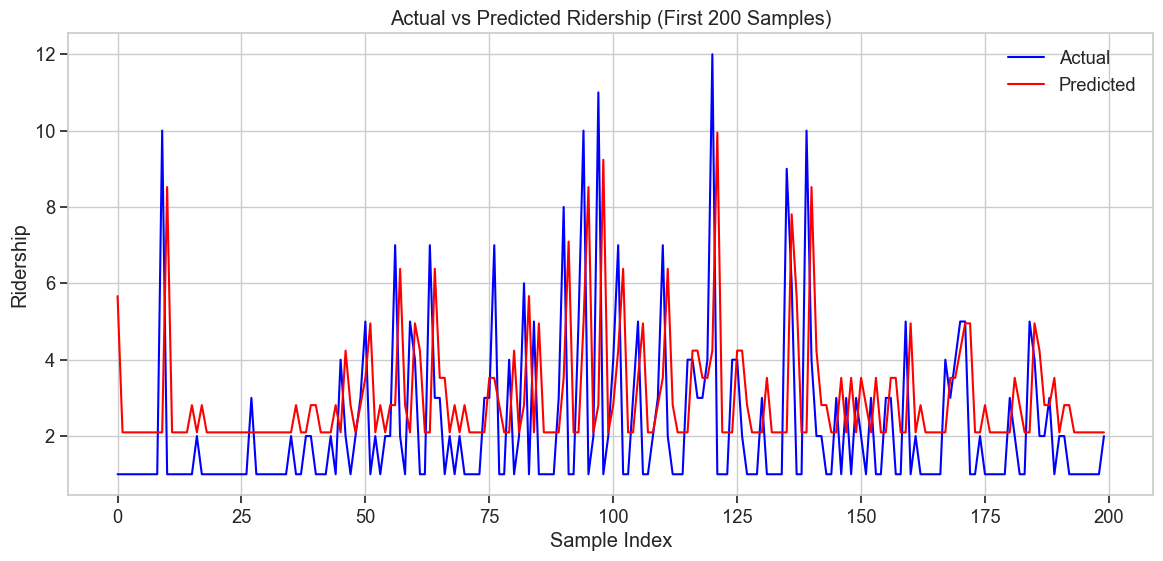

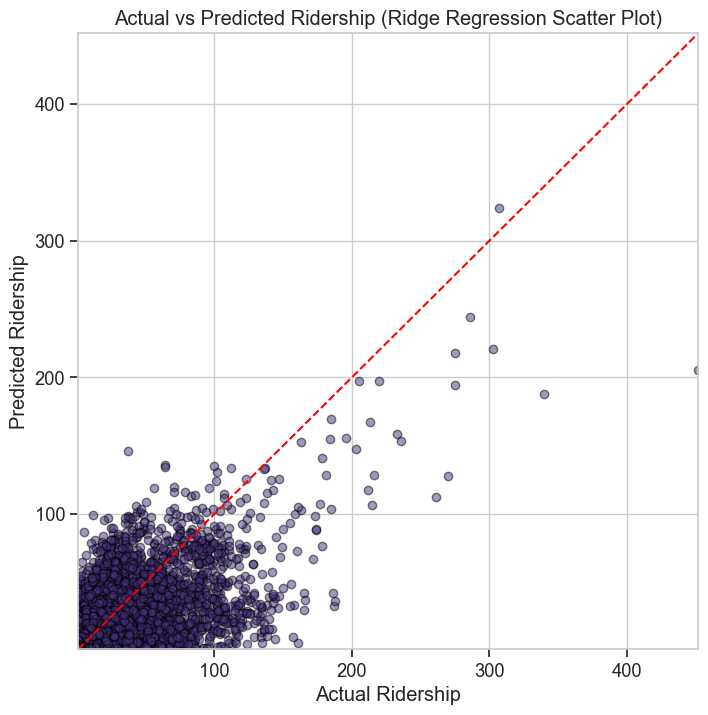

In [11]:
# Line Plot for Actual vs Predicted (First 200 Samples)
plt.figure(figsize=(14, 6))  # Ensure the figure size is large enough
plt.plot(y_test[:200].values, label='Actual', color='blue')
plt.plot(y_test_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)

# Remove tight_layout to avoid shrinking issues
# plt.tight_layout()
plt.show()

# Scatter Plot for Actual vs Predicted
plt.figure(figsize=(8, 8))  # Ensure the figure size is sufficient
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Ridge Regression Scatter Plot)')
plt.grid(True)

# Manually set the axis limits for consistency
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])

# Remove tight_layout to avoid shrinking
# plt.tight_layout()
plt.show()


## **Conclusion**

In [10]:
print("\nConclusion:")
print("The Linear Regression model shows moderate performance.")

if test_r2 >= 0.7:
    print(f"R² on the test set is {test_r2:.2f}, indicating decent predictive power.")
elif test_r2 >= 0.4:
    print(f"R² on the test set is {test_r2:.2f}, suggesting the model captures some patterns but may miss important information.")
else:
    print(f"R² on the test set is {test_r2:.2f}, indicating weak predictive power.")

if abs(train_r2 - test_r2) < 0.1:
    print("The training and test R² scores are close, meaning the model generalizes reasonably well.")
elif train_r2 > test_r2:
    print("The training R² is higher than the test R², indicating potential overfitting.")
else:
    print("The test R² is unexpectedly higher than training, which might suggest underfitting or data variance.")




Conclusion:
The Linear Regression model shows moderate performance.
R² on the test set is 0.46, suggesting the model captures some patterns but may miss important information.
The training and test R² scores are close, meaning the model generalizes reasonably well.


## **Model Saving and Persistence**

Now that we've trained and evaluated our Linear Regression model, let's save it along with the necessary artifacts for later use in production. This includes:

1. The trained Linear Regression model
2. The feature scaler used to normalize input data
3. The selected features list
4. Model evaluation metrics

These files will be saved in the models directory for easy access and deployment.

In [12]:
# Create models directory if it doesn't exist
import os
from pathlib import Path
import joblib

model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# 1. Save the trained Linear Regression model
model_path = model_dir / 'linear_regression_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Linear Regression model saved to {model_path}")

# 2. Save the feature scaler
scaler_path = model_dir / 'linear_regression_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Feature scaler saved to {scaler_path}")

# 3. Save selected features list
feature_list_path = model_dir / 'linear_regression_features.pkl'
joblib.dump(selected_features, feature_list_path)
print(f"✅ Selected features saved to {feature_list_path}")

# 4. Save model evaluation results
eval_results = {
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_mae': train_mae,
    'test_mae': test_mae,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'model_coefficients': model.coef_,
    'model_intercept': model.intercept_
}

eval_path = model_dir / 'linear_regression_evaluation.pkl'
joblib.dump(eval_results, eval_path)
print(f"✅ Model evaluation metrics saved to {eval_path}")

✅ Linear Regression model saved to ..\models\linear_regression_model.pkl
✅ Feature scaler saved to ..\models\linear_regression_scaler.pkl
✅ Selected features saved to ..\models\linear_regression_features.pkl
✅ Model evaluation metrics saved to ..\models\linear_regression_evaluation.pkl


In [13]:
# Example of how to load the saved model for inference
def load_linear_regression_model():
    """Load the saved Linear Regression model and related artifacts."""
    model_dir = Path('../models')
    
    # Load the model
    model = joblib.load(model_dir / 'linear_regression_model.pkl')
    
    # Load the scaler
    scaler = joblib.load(model_dir / 'linear_regression_scaler.pkl')
    
    # Load the selected features
    selected_features = joblib.load(model_dir / 'linear_regression_features.pkl')
    
    return model, scaler, selected_features

# Example prediction function
def predict_ridership(data, model, scaler, selected_features):
    """Make predictions using the saved Linear Regression model.
    
    Args:
        data: DataFrame containing features
        model: Loaded Linear Regression model
        scaler: Loaded feature scaler
        selected_features: List of features used by the model
        
    Returns:
        Numpy array of predictions
    """
    # Extract required features
    X = data[selected_features]
    
    # Scale the features
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = model.predict(X_scaled)
    
    return predictions

# This is a demonstration - no need to run this now
'''
# Load the saved model and artifacts
model, scaler, selected_features = load_linear_regression_model()

# Example: Make predictions on new data
new_data = pd.read_csv('path_to_new_data.csv')
predictions = predict_ridership(new_data, model, scaler, selected_features)
'''

print("✅ Added example code for loading and using the saved model")

✅ Added example code for loading and using the saved model
